In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Per la divisione del dataset
from sklearn.model_selection import train_test_split
# Per la valutazione
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# Per riproducibilità
np.random.seed(42)

### Previsione dei Guasti nelle Reti di Telecomunicazioni

In [17]:
# Lettura dataset
network_df = pd.read_csv('network_failure_data.csv')
print(network_df.head())

   users_density  call_volume  data_traffic  maintenance_frequency  \
0            112         2100    869.589780               0.962160   
1            445         2856    729.897379               4.257256   
2            358         1768    745.279456              11.300709   
3            280         1560    431.238401               8.022872   
4            116         3736    352.475643               8.144039   

   temperature  failure  
0    27.133696        0  
1    10.476685        0  
2    21.587243        1  
3    30.073899        0  
4    14.482994        1  


### Data exploration


Distribuzione dei guasti:
failure
0    0.501
1    0.499
Name: proportion, dtype: float64


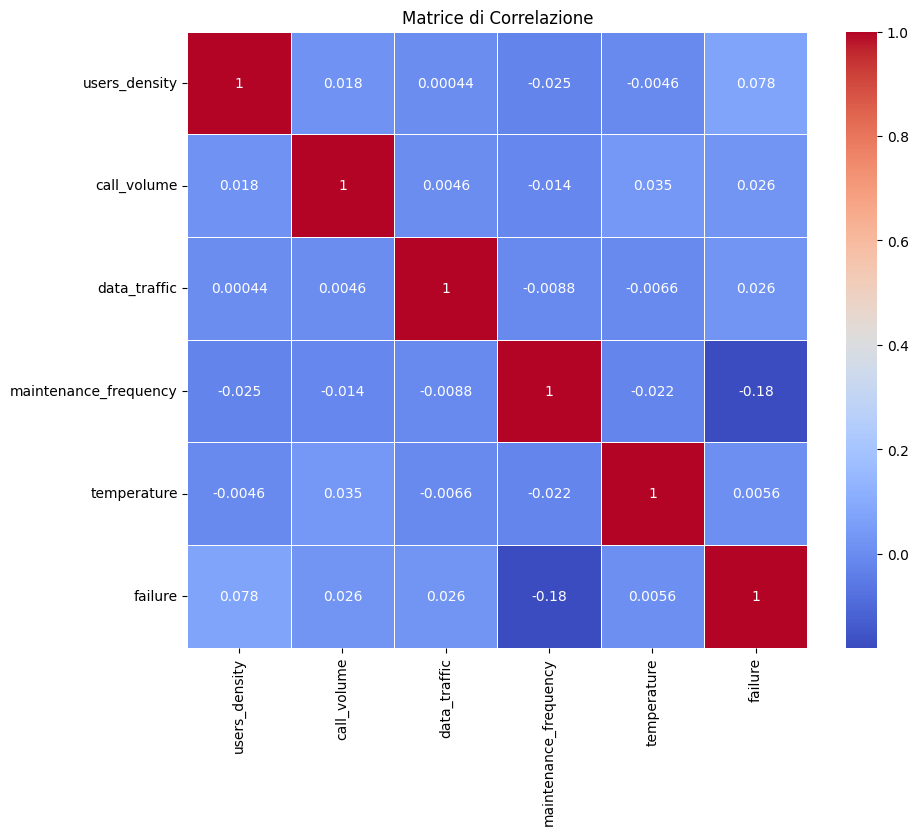

In [18]:

# Verifica della distribuzione della variabile target
print("\nDistribuzione dei guasti:")
print(network_df['failure'].value_counts(normalize=True))

# Visualizzazione della correlazione tra le variabili
plt.figure(figsize=(10, 8))
correlation_matrix = network_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matrice di Correlazione')
plt.show()
features = network_df.columns[:-1]  # Tutte le colonne tranne 'failure'


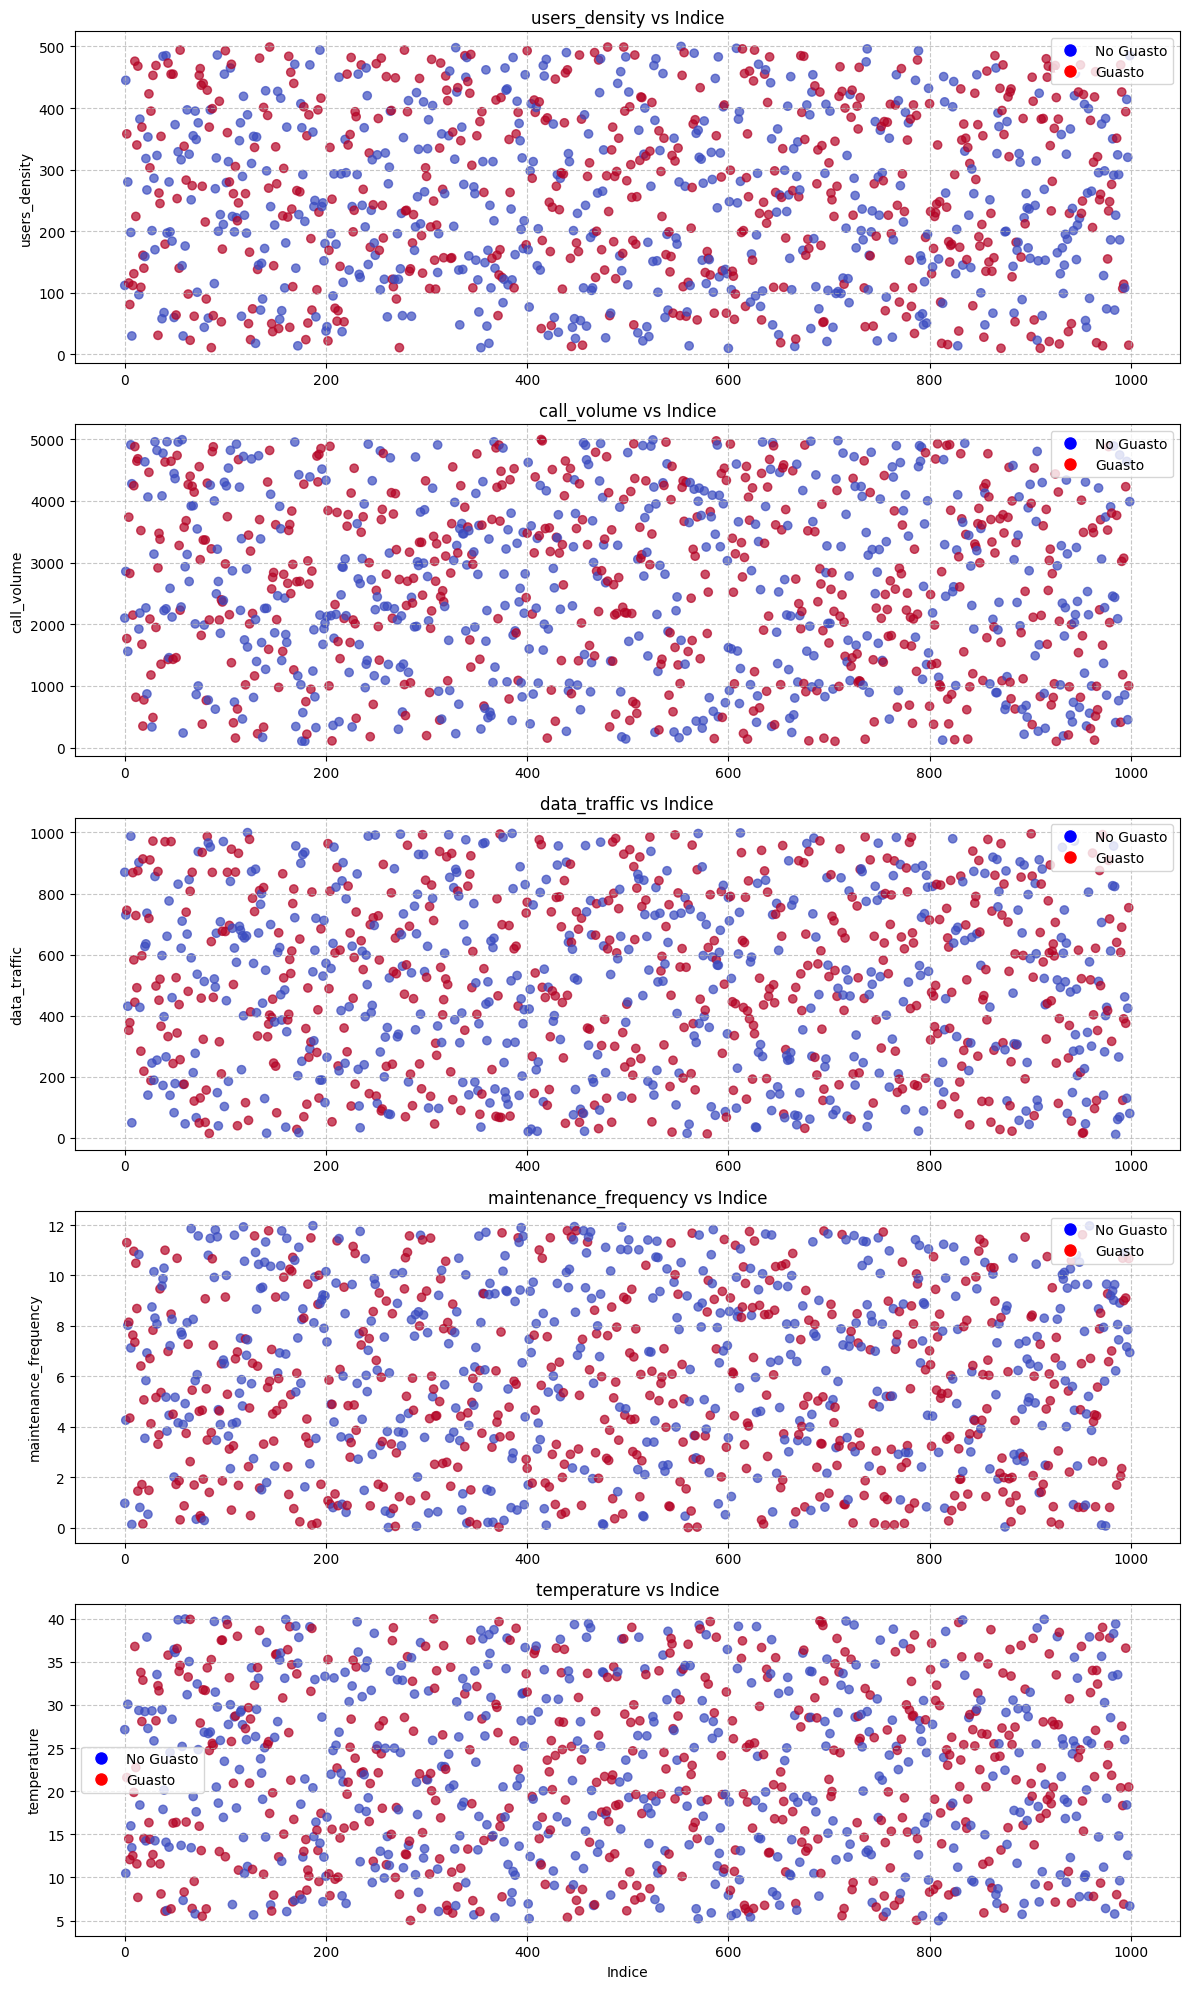

In [19]:
# Scatter plot individuali per ogni caratteristica vs indice con colore basato su 'failure'
fig, axes = plt.subplots(len(features), 1, figsize=(12, 4*len(features)))

for i, feature in enumerate(features):
    ax = axes[i]
    scatter = ax.scatter(range(len(network_df)), network_df[feature], 
                         c=network_df['failure'], cmap='coolwarm', alpha=0.7)
    ax.set_title(f'{feature} vs Indice')
    ax.set_ylabel(feature)
    if i == len(features)-1:
        ax.set_xlabel('Indice')
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Aggiunge una legenda
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='o', color='w', 
                              markerfacecolor='blue', markersize=10, label='No Guasto'),
                       Line2D([0], [0], marker='o', color='w', 
                              markerfacecolor='red', markersize=10, label='Guasto')]
    ax.legend(handles=legend_elements, loc='best')

plt.tight_layout()
plt.show()

In [20]:
# Separazione feature e target
X = network_df.drop('failure', axis=1)
y = network_df['failure']
# Divisione in training e test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Dimensioni del training set:", X_train.shape)
print("Dimensioni del test set:", X_test.shape)

Dimensioni del training set: (800, 5)
Dimensioni del test set: (200, 5)


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class LogisticRegression:
    """
    Implementazione da zero della regressione logistica utilizzando
    la discesa del gradiente.
    """
    
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        """
        Inizializzazione del modello
        
        Parametri:
        learning_rate: tasso di apprendimento per la discesa del gradiente
        n_iterations: numero di iterazioni per la discesa del gradiente
        """
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.cost_history = []
    
    def sigmoid(self, z):
        """
        Funzione sigmoide: trasforma un numero reale in una probabilità (0-1)
        """
        # Limitiamo z per evitare overflow/underflow numerici
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    def predict_raw(self, X, weights):
        """
        Calcola le previsioni usando il modello lineare y = X*w.
        
        Parametri:
        X -- matrice di input di shape (m, n+1) con una colonna di 1 aggiunta per il termine di bias
        weights -- vettore dei pesi di shape (n+1, 1)
        
        Restituisce:
        predictions -- vettore delle previsioni di shape (m, 1)
        """
        return np.dot(X, weights)

    def compute_cost(self, X, y, weights):
        """
        Calcola la funzione di costo (log loss)
        
        J(w) = -1/m * sum(y*log(h) + (1-y)*log(1-h))
        
        dove:
        m = numero di esempi
        h = sigmoid(X*w) = previsione
        """
        m = X.shape[0]
        z = self.predict_raw(X, weights) # predictions
        h = self.sigmoid(z) # Applico la sigmoide
        
        # Per evitare log(0), limitiamo h a valori molto piccoli ma non zero
        epsilon = 1e-15
        h = np.clip(h, epsilon, 1 - epsilon)
        # Clip serve a limitare i valori di h tra epsilon e 1-epsilon
        # se h fosse 0, log(0) diverrebbe -inf, se h fosse 1, log(1-h) sarebbe -inf
        
        cost = -1/m * np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))
        return cost
    
    def compute_gradient(self, X, y, weights):
        """
        Calcola il gradiente della funzione di costo rispetto ai pesi
        
        gradient = (1/m) * X^T * (h - y)
        
        dove:
        m = numero di esempi
        h = sigmoid(X*w) = previsione
        """
        m = X.shape[0]
        z = np.dot(X, weights)
        h = self.sigmoid(z)
        
        # Calcolo del gradiente
        gradient = 1/m * np.dot(X.T, (h - y))
        return gradient

    def gradient_descent(self, X, y):
        """
        Implementa la discesa del gradiente per trovare i pesi ottimali
        
        L'aggiornamento dei pesi avviene secondo la formula:
        w = w - learning_rate * gradiente
        """
        m, n = X.shape
        self.weights = np.zeros(n)
        
        for i in range(self.n_iterations):
            # Calcolo del gradiente
            gradient = self.compute_gradient(X, y, self.weights)
            
            # Aggiornamento dei pesi
            self.weights = self.weights - self.learning_rate * gradient
            
            # Salvataggio del costo per questa iterazione
            cost = self.compute_cost(X, y, self.weights)
            self.cost_history.append(cost)
            
            # Stampa periodica del costo
            if (i % 100 == 0) or (i == self.n_iterations - 1):
                print(f"Iterazione {i}: Costo = {cost:.6f}")
    
    def fit(self, X, y):
        """
        Addestra il modello sui dati
        """
        # Convertiamo X e y in array numpy se non lo sono già
        X_array = X.values if isinstance(X, pd.DataFrame) else X
        y_array = y.values if isinstance(y, pd.Series) else y
        
        print("Avvio addestramento...")
        self.gradient_descent(X_array, y_array)
        print("Addestramento completato!")
        
        # Se X era un DataFrame, salviamo anche i nomi delle feature
        if isinstance(X, pd.DataFrame):
            self.feature_names = X.columns
    
    def predict_proba(self, X):
        """
        Prevede la probabilità di appartenenza alla classe positiva
        """
        X_array = X.values if isinstance(X, pd.DataFrame) else X
        return self.sigmoid(np.dot(X_array, self.weights))
    
    def predict(self, X, threshold=0.5):
        """
        Prevede la classe (0 o 1) usando una soglia
        """
        return (self.predict_proba(X) >= threshold).astype(int)
    
    def plot_cost_history(self):
        """
        Visualizza l'andamento della funzione di costo durante l'addestramento
        """
        plt.figure(figsize=(10, 6))
        plt.plot(range(self.n_iterations), self.cost_history)
        plt.xlabel('Iterazioni')
        plt.ylabel('Costo')
        plt.title('Andamento della funzione di costo')
        plt.grid(True)
        plt.show()

Avvio addestramento...
Iterazione 0: Costo = 16.812155
Iterazione 100: Costo = 16.924000
Iterazione 200: Costo = 16.967176
Iterazione 300: Costo = 16.794482
Iterazione 400: Costo = 16.837656
Iterazione 500: Costo = 16.880831
Iterazione 600: Costo = 16.880831
Iterazione 700: Costo = 16.837657
Iterazione 800: Costo = 16.708137
Iterazione 900: Costo = 16.708137
Iterazione 999: Costo = 17.701524
Addestramento completato!


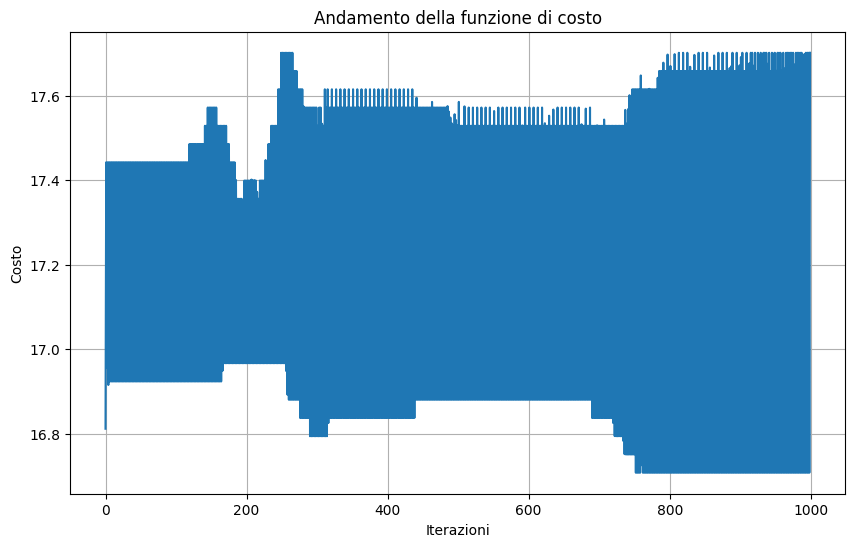

In [22]:
# Istanziazione del modello
logistic_model = LogisticRegression(learning_rate=0.05, n_iterations=1000)
# Addestramento del modello
X_train['intercept'] = 1
logistic_model.fit(X_train, y_train)
# Visualizzazione dell'andamento della funzione di costo
logistic_model.plot_cost_history()

In [24]:
X

,users_density,call_volume,data_traffic,maintenance_frequency,temperature
0,112,2100,869.589780,0.962160,27.133696
1,445,2856,729.897379,4.257256,10.476685
2,358,1768,745.279456,11.300709,21.587243
3,280,1560,431.238401,8.022872,30.073899
4,116,3736,352.475643,8.144039,14.482994
...,...,...,...,...,...
995,394,4230,375.362492,9.104584,36.584115
996,414,4640,129.814750,7.165864,18.412538
997,320,452,424.758312,7.849593,12.571647
998,15,1002,753.666267,10.669535,20.490207


### COSA E' SUCCESSO?

In [ ]:
# Normalizzazione delle feature (importante per la regressione logistica)
def normalize_with_params(X, means=None, stds=None):
    X_norm = X.copy()
    if means is None or stds is None:  # Calcola parametri da X
        means = {}
        stds = {}
        for feature in X.columns:
            means[feature] = X[feature].mean()
            stds[feature] = X[feature].std()
    
    # Applica la normalizzazione
    for feature in X.columns:
        X_norm[feature] = (X[feature] - means[feature]) / stds[feature]
    
    return X_norm, means, stds

# Sul training set:
X_normalized_train, means, stds = normalize_with_params(X_train)
X_normalized_train['intercept'] = 1

# Sul test set (usando gli stessi parametri):
X_normalized_test, _, _ = normalize_with_params(X_test, means, stds)
X_normalized_test['intercept'] = 1



In [26]:
X_normalized_train

,users_density,call_volume,data_traffic,maintenance_frequency,temperature,intercept
29,0.215383,0.377149,-1.083977,1.206087,0.345098,1
535,1.427553,1.183970,0.038556,-0.989874,1.338798,1
695,-1.446003,-1.705509,-1.185916,1.667822,1.039624,1
557,0.122688,-0.868677,0.982954,-1.562429,1.217521,1
836,0.678860,0.599793,0.675593,1.098234,-0.593797,1
...,...,...,...,...,...,...
106,1.534509,-0.851926,1.534382,-1.493642,0.337593,1
270,-1.182178,0.428099,0.122895,-0.845479,-0.427238,1
860,-0.034181,-1.091320,-0.255677,-1.026935,-1.298386,1
435,-1.068091,0.484632,-0.204057,-1.123258,0.244695,1


Avvio addestramento...
Iterazione 0: Costo = 0.693095
Iterazione 100: Costo = 0.688525
Iterazione 200: Costo = 0.684990
Iterazione 300: Costo = 0.682254
Iterazione 400: Costo = 0.680133
Iterazione 500: Costo = 0.678487
Iterazione 600: Costo = 0.677207
Iterazione 700: Costo = 0.676212
Iterazione 800: Costo = 0.675436
Iterazione 900: Costo = 0.674831
Iterazione 1000: Costo = 0.674358
Iterazione 1100: Costo = 0.673988
Iterazione 1200: Costo = 0.673698
Iterazione 1300: Costo = 0.673471
Iterazione 1400: Costo = 0.673293
Iterazione 1500: Costo = 0.673153
Iterazione 1600: Costo = 0.673043
Iterazione 1700: Costo = 0.672956
Iterazione 1800: Costo = 0.672889
Iterazione 1900: Costo = 0.672835
Iterazione 2000: Costo = 0.672793
Iterazione 2100: Costo = 0.672760
Iterazione 2200: Costo = 0.672733
Iterazione 2300: Costo = 0.672713
Iterazione 2400: Costo = 0.672697
Iterazione 2500: Costo = 0.672684
Iterazione 2600: Costo = 0.672674
Iterazione 2700: Costo = 0.672666
Iterazione 2800: Costo = 0.672659
Ite

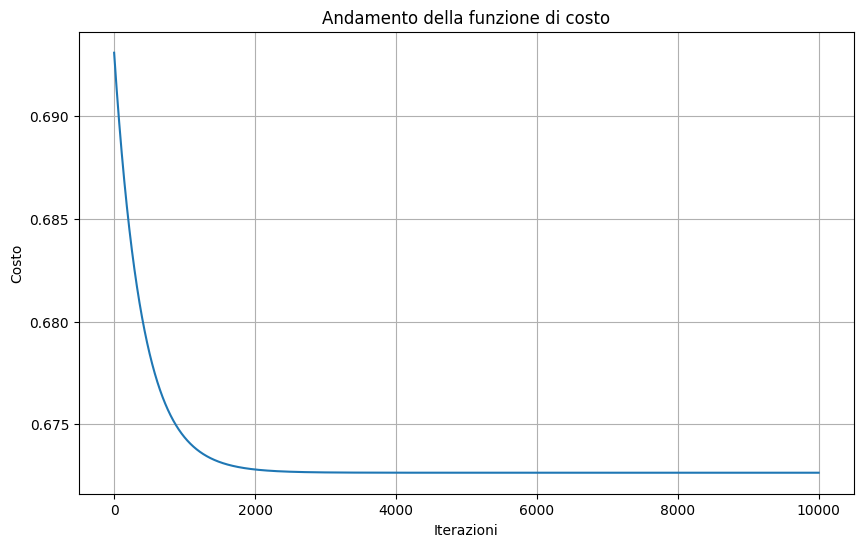

In [27]:
logistic_model = LogisticRegression(learning_rate=0.005, n_iterations=10000)
logistic_model.fit(X_normalized_train, y_train)

y_pred = logistic_model.predict(X_normalized_test)
logistic_model.plot_cost_history()

Coefficienti del modello:
                 Feature  Coefficiente  Valore Assoluto
3  maintenance_frequency     -0.378914         0.378914
0          users_density      0.150052         0.150052
5              intercept     -0.020850         0.020850
1            call_volume      0.015995         0.015995
2           data_traffic     -0.009138         0.009138
4            temperature      0.006532         0.006532


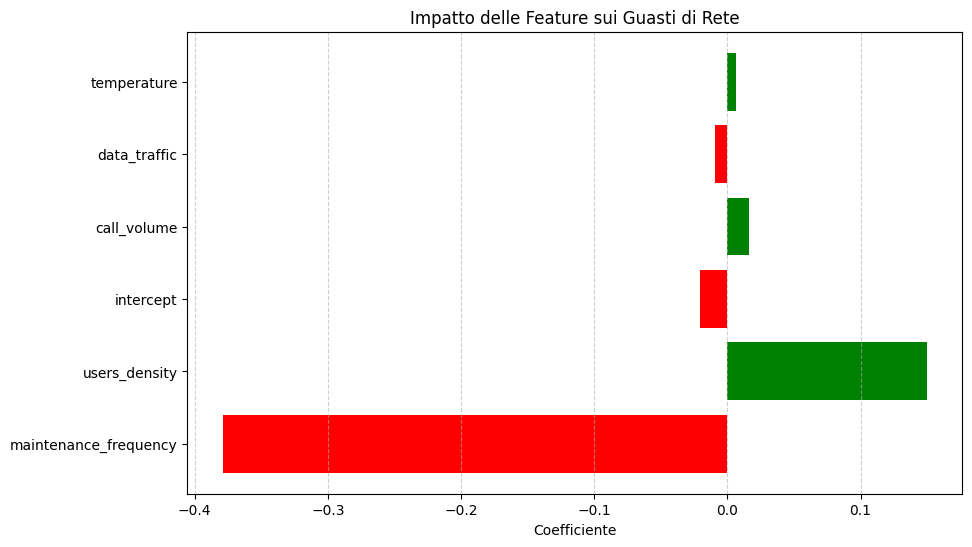

In [28]:
# Creazione di un DataFrame per visualizzare i coefficienti
if hasattr(logistic_model, 'feature_names'):
    coef_df = pd.DataFrame({
        'Feature': logistic_model.feature_names,
        'Coefficiente': logistic_model.weights
    })
else:
    coef_df = pd.DataFrame({
        'Feature': X_train.columns if isinstance(X_train, pd.DataFrame) else [f'X{i}' for i in range(X_train.shape[1])],
        'Coefficiente': logistic_model.weights
    })

# Ordina i coefficienti per valore assoluto
coef_df['Valore Assoluto'] = np.abs(coef_df['Coefficiente'])
coef_df = coef_df.sort_values('Valore Assoluto', ascending=False)

print("Coefficienti del modello:")
print(coef_df)

# Visualizzazione grafica dei coefficienti
plt.figure(figsize=(10, 6))
colors = ['red' if c < 0 else 'green' for c in coef_df['Coefficiente']]
plt.barh(coef_df['Feature'], coef_df['Coefficiente'], color=colors)
plt.xlabel('Coefficiente')
plt.title('Impatto delle Feature sui Guasti di Rete')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()



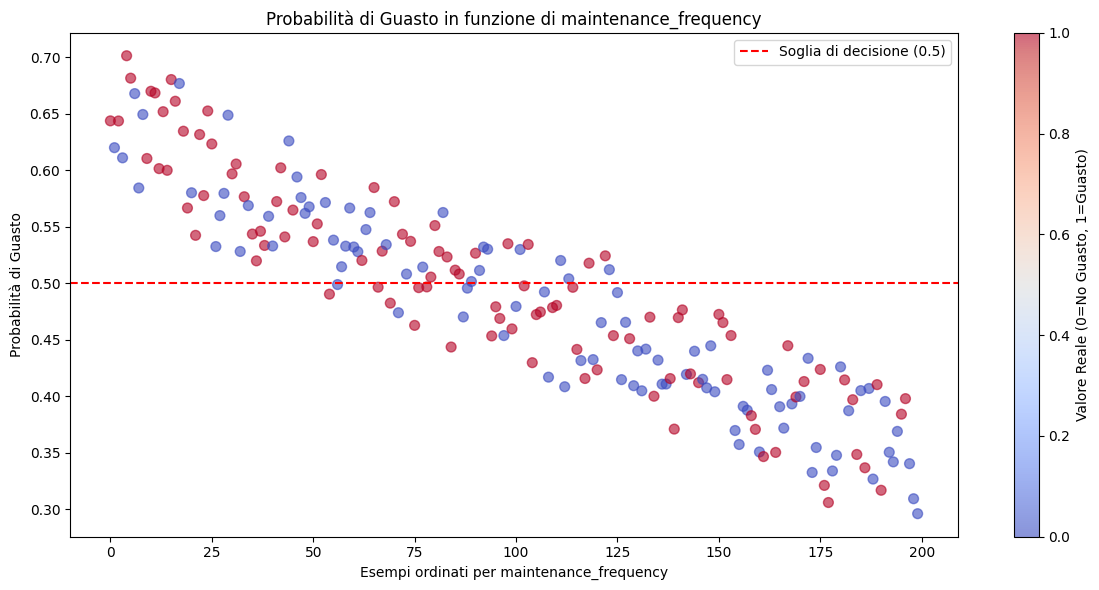

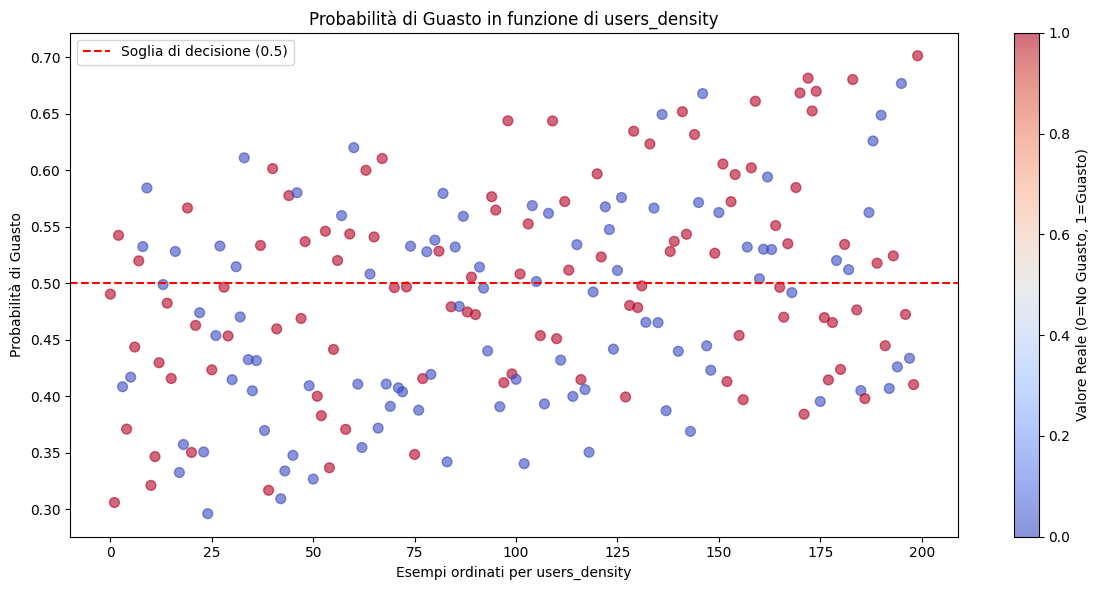

In [ ]:
# Troviamo la feature più importante (escludendo l'intercetta)
important_features = coef_df[coef_df['Feature'] != 'intercept'].head(2)['Feature'].tolist()

# Per ogni feature importante, creiamo un grafico
for feature in important_features:
    # Ordiniamo il test set in base a questa feature
    idx = X_normalized_test.columns.get_loc(feature)
    sorted_indices = X_normalized_test.iloc[:, idx].argsort()
    
    feature_values = X_normalized_test.iloc[sorted_indices, idx]
    predicted_probs = logistic_model.predict_proba(X_normalized_test.iloc[sorted_indices])
    actual_values = y_test.iloc[sorted_indices]
    
    plt.figure(figsize=(12, 6))
    
    # Plot delle probabilità previste
    plt.scatter(range(len(feature_values)), predicted_probs, 
               c=actual_values, cmap='coolwarm', alpha=0.6, s=50)
    
    plt.axhline(y=0.5, color='r', linestyle='--', label='Soglia di decisione (0.5)')
    
    plt.colorbar(label='Valore Reale (0=No Guasto, 1=Guasto)')
    plt.xlabel('Esempi ordinati per ' + feature)
    plt.ylabel('Probabilità di Guasto')
    plt.title(f'Probabilità di Guasto in funzione di {feature}')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [29]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# Creare e addestrare il modello
model = LogisticRegression(random_state=42, max_iter=10000)
model.fit(X_train, y_train)
X_test['intercept'] = 1
# Fare previsioni
y_pred = model.predict(X_test)

print("\nPesi del modello:")
for feature, coef in zip(X.columns, model.coef_[0]):
    print(f"{feature}: {coef:.4f}")

print("Intercept:", model.intercept_[0])



Pesi del modello:
users_density: 0.0011
call_volume: 0.0000
data_traffic: -0.0000
maintenance_frequency: -0.1081
temperature: 0.0007
Intercept: 0.31826263701592217


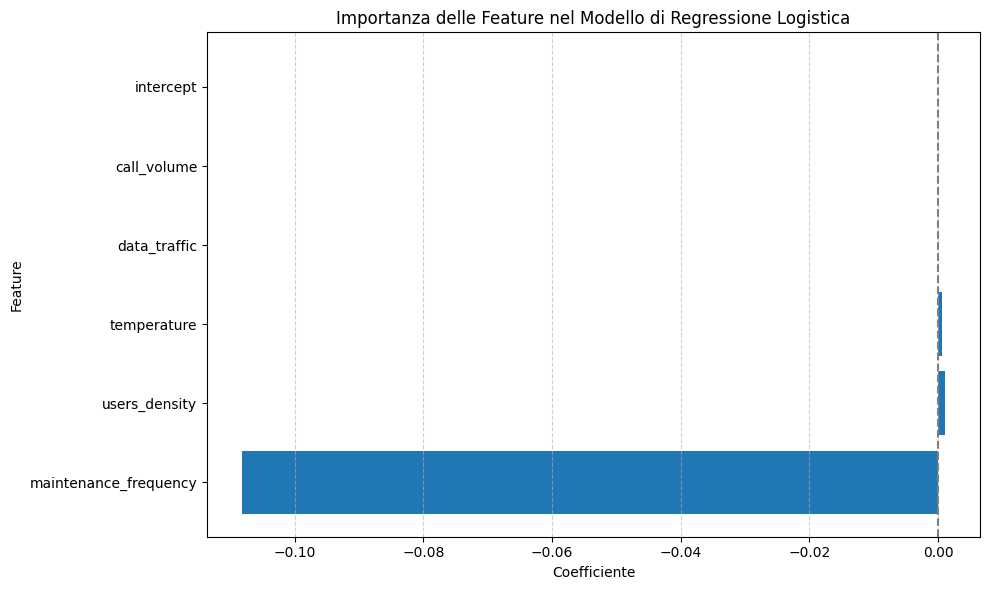

In [ ]:
# Visualizzazione grafica dei coefficienti
plt.figure(figsize=(10, 6))
coefficients = pd.DataFrame({
    'Feature': X_test.columns,
    'Coefficient': model.coef_[0]
})

# Ordina i coefficienti per valore assoluto per evidenziare quelli più importanti
coefficients = coefficients.reindex(coefficients['Coefficient'].abs().sort_values(ascending=False).index)

# Crea il grafico a barre
plt.barh(coefficients['Feature'], coefficients['Coefficient'])
plt.xlabel('Coefficiente')
plt.ylabel('Feature')
plt.title('Importanza delle Feature nel Modello di Regressione Logistica')
plt.axvline(x=0, color='gray', linestyle='--')  # Linea verticale sullo zero
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()